#### Functions (IGNORE)

##### Packages

In [1]:
import pandas as pd
from datetime import timedelta
import numpy as np
import matplotlib.pyplot as plt

##### Stochastic Modeling

In [2]:
def add_signals(periods, technique_weights, tickers, nested_technique_signals):
    """
    Aggregate weighted signals from multiple techniques for each period.

    Args:
        periods (list): List of economic periods (e.g., 'trough', 'expansion').
        technique_weights (dict): Dictionary of weights for each technique (e.g., {'Bollinger': 0.4, 'RSI': 0.6}).
        tickers (list): List of tickers for which signals are tracked.
        nested_technique_signals (dict): Nested dictionary containing signal DataFrames, structured as:
                                         {period: {technique: DataFrame}}

    Returns:
        dict: A dictionary of aggregated weighted signals for each period.
    """
    # Initialize signals dictionary with DataFrames of zeros for each period
    signals = {period: pd.DataFrame(0, columns=tickers, index=nested_technique_signals[period]['Bollinger'].index) 
               for period in periods}
               
    
    # Loop through each period
    for period in periods:
        # Loop through each technique and its corresponding weight
        for technique, weight in technique_weights.items():
            # Check if the technique exists in the current period's signals
            if technique in nested_technique_signals[period]:
                # Access the technique signals for the current period
                df = nested_technique_signals[period][technique]

                df = df.apply(pd.to_numeric, errors='coerce').fillna(0)

                # Ensure that the signal value is either 0 or the weighted value
                weighted_df = df * weight

                # Add the weighted signal for each ticker, ensuring alignment and presence of data
                signals[period] += weighted_df
    
    return signals

In [3]:
def grid_weighted_technique_roi(technique_weights, signals_nd, adj_close_nd, periods_date, periods_list, tickers, n_sample, initial_investment, future_investments, percent_to_buy, percent_to_sell):
    import random
    random.seed(4)
    np.random.seed(4)
    # Initialize a nested dictionary to store ROI percentages for each period and ticker
    roi_results = {period: {ticker: [] for ticker in tickers} for period in periods_list}

    # Loop through each economic period
    for period in periods_list:
        # Create the date range for the current period
        date_range = pd.date_range(start=pd.to_datetime(periods_date[period][0]), end=pd.to_datetime(periods_date[period][1]) - timedelta(days=110))
        
        # Get random dates for stochastic modeling
        start_dates = np.random.choice(date_range, size=n_sample, replace=True)

        # Loop through sampled start dates
        for start_date in start_dates:
            time_stamp = pd.to_datetime(start_date)

            # Extract the adjusted close data and calculate weighted signals for the time period
            adj_close_period = adj_close_nd[period].loc[time_stamp:time_stamp + timedelta(days=110)]
            weighted_signals = add_signals(periods_list,technique_weights,tickers,signals_nd)[period].loc[time_stamp:time_stamp + timedelta(days=110)]

            # Initialize variables for each ticker
            account_balance = {ticker: future_investments for ticker in tickers}  # Separate account balance for each stock
            shares_number = {ticker: initial_investment / adj_close_period[ticker].iloc[0] for ticker in tickers}  # Initialize share count for each ticker
            shares_value = {ticker: initial_investment for ticker in tickers}   # Initialize share value for each ticker

            # Iterate over each day in the weighted signals and adjusted close prices
            for row_idx, (signals_row, adj_close_row) in enumerate(zip(weighted_signals.iterrows(), adj_close_period.iterrows())):
                signals_row = signals_row[1]  # Extract the actual row (signals) - don't need the index
                adj_close_row = adj_close_row[1]  # Extract the actual row (adjusted close prices)

                # Now zip over the signal row and the corresponding adjusted close price for each ticker
                for ticker, (signal, adj_close_price) in zip(tickers, zip(signals_row, adj_close_row)):
                    
                    # Handle Buy action
                    if signal > 0:
                        amount_to_buy = percent_to_buy * account_balance[ticker] * signal
                        if account_balance[ticker] >= amount_to_buy:
                            shares_to_buy = amount_to_buy / adj_close_price
                            shares_number[ticker] += shares_to_buy
                            account_balance[ticker] -= amount_to_buy

                    # Handle Sell action
                    elif signal < 0:
                        if shares_number[ticker] > 0:
                            shares_value[ticker] = shares_number[ticker] * adj_close_price
                            amount_to_sell = percent_to_sell * shares_value[ticker] * signal
                            if shares_value[ticker] >= amount_to_sell:
                                shares_to_sell = amount_to_sell / adj_close_price
                                shares_number[ticker] -= shares_to_sell
                                account_balance[ticker] += amount_to_sell

            # Calculate total portfolio value for each stock at the end of the period
            for ticker in tickers:
                if shares_number[ticker] > 0:  # Only calculate value if shares are owned
                    portfolio_value = shares_number[ticker] * adj_close_period.iloc[-1][ticker]
                    total_value = account_balance[ticker] + portfolio_value
                    
                    # Calculate profit for this stock
                    profit = total_value - (initial_investment + future_investments)
                    
                    # Calculate ROI based on stock's individual account
                    roi_dollar_value = (profit / (initial_investment + future_investments)) * 100
                else:
                    roi_dollar_value = 0

                # Store ROI in the results dictionary
                roi_results[period][ticker].append(roi_dollar_value)

    return roi_results


In [4]:
def signal_replacement(nested_dict,periods,strategies):

    signal_mapping = {'Buy': 1, 'Sell': -1, 'Hold': 0}

    for period in periods:
        for strategy in strategies:
            if period in nested_dict and strategy in nested_dict[period]:
                nested_dict[period][strategy] = (
                    nested_dict[period][strategy]
                    .applymap(lambda x: signal_mapping.get(x, x))  # Replace signals
                )

    return nested_dict

In [5]:
import pandas as pd

def collect_signals(data, list_techniques, tickers, periods):
    # Initialize a nested dictionary for signals
    signals_nd = {period: {technique: pd.DataFrame(columns=tickers) for technique in list_techniques} for period in periods}
    
    for period in periods:
        for technique in list_techniques:
            for ticker in tickers:
                # Check if the period and ticker exist in the data
                if period in data and ticker in data[period]:
                    # Check if the technique's signal exists
                    signal_column = f'{technique} Signal'
                    if signal_column in data[period][ticker].columns:
                        # Collect the signals for the specified period, technique, and ticker
                        signals_nd[period][technique][ticker] = data[period][ticker][signal_column]
                    else:
                        # Handle the case where the signal column doesn't exist
                        signals_nd[period][technique][ticker] = pd.Series([None] * len(data[period][ticker]), index=data[period][ticker].index)
                else:
                    # Handle missing period or ticker data
                    signals_nd[period][technique][ticker] = pd.Series([None] * len(data[period][ticker]), index=data[period][ticker].index)

    return signals_nd


In [6]:
def stochastic_roi(tickers,periods,return_rates_list,analysis_type):
    df = pd.DataFrame(index=tickers,columns=periods)
    for period in periods:
        for ticker in tickers:
            data = pd.Series(return_rates_list[period][ticker])
            if analysis_type=='Mean':
                df.at[ticker,period] = data.mean()
            elif analysis_type=='Median':
                df.at[ticker,period] = data.median()
            elif analysis_type=='Std':
                df.at[ticker,period] = data.std()
            elif analysis_type=='Variance':
                df.at[ticker,period] = data.var()

    return df

##### Weights

In [7]:
from itertools import product
import pandas as pd

def normalize_weights(weight_dict):
    """
    Normalize the weights so that their sum is equal to 1.
    
    Args:
        weight_dict (dict): Dictionary of technique weights.
    
    Returns:
        dict: Normalized weight dictionary where the sum of weights is 1.
    """
    total_weight = sum(weight_dict.values())
    
    # Ensure we don't divide by zero in case the sum is zero
    if total_weight != 0:
        normalized_weights = {technique: weight / total_weight for technique, weight in weight_dict.items()}
    else:
        normalized_weights = {technique: 0 for technique in weight_dict}  # If sum is zero, all weights are zero
    
    return normalized_weights

In [8]:

def grid_search_weighted_technique_roi(technique_weights_grid, signals_nd, adj_close_nd, periods_date, periods_list, tickers, n_sample, initial_investment, future_investments, percent_to_buy, percent_to_sell):
    # Store results for each weight combination
    results = []
    
    # Iterate over combinations of weights
    for weights in product(*technique_weights_grid.values()):
        weight_dict = dict(zip(technique_weights_grid.keys(), weights))
        
        # Normalize the weights so their sum equals 1
        normalized_weights = normalize_weights(weight_dict)
        
        # Calculate ROI for the current combination of weights
        roi_results = grid_weighted_technique_roi(normalized_weights, signals_nd, adj_close_nd, periods_date, periods_list, tickers, n_sample, initial_investment, future_investments, percent_to_buy, percent_to_sell)
        
        # Average the ROI across all periods and tickers
        average_roi = stochastic_roi(tickers, periods_date, roi_results, 'Mean').mean()

        # Append the result (weights and average ROI) to the results list
        results.append({
            'weights': normalized_weights,
            'trough': average_roi[0],
            'expansion': average_roi[1],
            'peak': average_roi[2],
            'contraction': average_roi[3],
            'all_data': average_roi[4],
        })
    
    # Convert the results list to a DataFrame
    roi_df = pd.DataFrame(results)
    
    return roi_df

##### Collect Data

In [9]:
import yfinance as yf
missing_data_tickers = [] # use this as a list of tickers with missing data

def get_data_from_start_to_end(ticker, start_date, end_date):
    global missing_data_tickers  # Use the global list to accumulate missing tickers
    try:
        stock_data = yf.download(ticker, start=start_date, end=end_date)
        if stock_data.empty:
            missing_data_tickers.append(ticker)
            raise ValueError(f"Stock data for ticker {ticker} during the period from {start_date} to {end_date} was not found.")
        return stock_data
    except Exception as e:
        print(f"An error occurred for ticker {ticker}: {e}")
        missing_data_tickers.append(ticker)
        return None


In [10]:
# for a variety of periods load in different list of tickers
def download_stock_data_for_periods(tickers, periods):
    all_data = {}
    
    for period, (start_date, end_date) in periods.items():
        period_data = {}
        for ticker in tickers:
            data = get_data_from_start_to_end(ticker, start_date, end_date)
            if data is not None:
                period_data[ticker] = data
        all_data[period] = period_data
    
    return all_data

In [11]:
import pandas as pd

# Get the adjusted close prices
adj_close_sector_etf = {}

# Create adjusted close price only listing of sector ETFs
def get_adjusted_closed_price(nested_dict, tickers, periods):
    for period in periods:
        stock_price_df = pd.DataFrame()  # Create a new DataFrame for each period
        for ticker in tickers:
            stock_price_df[ticker] = nested_dict[period][ticker]['Adj Close']
        
        adj_close_sector_etf[period] = stock_price_df  # Store the complete DataFrame for the period
    
    return adj_close_sector_etf

##### Folder Load in

In [12]:
import os
import pandas as pd

# Define the root directory
root_dir = "/Users/ben_nicholson/Visual_Code_Projects/Personal_Projects/Financial Capstone Project/data/signal_data"

# Initialize an empty dictionary
signals_dict = {}

# Loop through the directories and files
for foldername, subfolders, filenames in os.walk(root_dir):
    # Get the signal type from the folder name (last part of the path)
    signal_type = os.path.basename(foldername)
    
    # Loop through the files
    for filename in filenames:
        # Check if the file is a CSV
        if filename.endswith('.csv'):
            # Extract the period from the file name (e.g., "expansion", "contraction", etc.)
            period = filename.split('_')[0]  # Assuming period is the first part of the file name

            # Initialize the dictionary for the period if not already present
            if period not in signals_dict:
                signals_dict[period] = {}

            # Build the full file path
            file_path = os.path.join(foldername, filename)
            
            # Read the CSV file into a DataFrame
            df = pd.read_csv(file_path)

            # Add the DataFrame to the nested dictionary under the corresponding period and signal type
            signals_dict[period][signal_type] = df.set_index('Date')

##### Bollinger Bands

In [13]:
# create bollinger bands
import scipy.stats as stats
def add_bollinger_data(data,window,conf_int):
        z_score = stats.norm.ppf(1 - (1 - conf_int) / 2) # create a zscore from the mean

        data['middle_band'] = data['Adj Close'].rolling(window).mean()
        data['upper_band'] = data['middle_band'] + z_score * data['Adj Close'].rolling(window).std()
        data['lower_band'] = data['middle_band'] - z_score * data['Adj Close'].rolling(window).std()

        data['Bollinger Signal'] = np.where(data['Adj Close'] < data['lower_band'], 'Buy', 
                              np.where(data['Adj Close'] > data['upper_band'], 'Sell', 'Hold'))

        return data

In [14]:
# create bollinger data for multiple time period and multiple tickers
def bollinger_data_multiple_periods_tickers(periods,tickers,data,window,confidence_period):
    # for each ticker in economic time periods
    for period in periods:
            for ticker in tickers:
                    try:
                        add_bollinger_data(data[period][ticker],window,confidence_period)
                    except KeyError:
                        print(f'Data for {ticker} does not exist during {period}')
    return data

##### RSI

In [15]:
def calculate_rsi(data, window):
    """
    Calculate the Relative Strength Index (RSI) for a given stock data series.

    Parameters:
    data (pd.Series): A pandas series of adjusted close prices.
    window (int): The lookback period for RSI calculation, default is 14.

    Returns:
    pd.Series: RSI values.
    """
    delta = data.diff()  # Difference in price from previous price
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()  # Average gain
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()  # Average loss
    
    # Avoid division by zero, especially at the beginning of the dataset
    rs = gain / loss.replace(0, np.nan)  
    
    # RSI formula
    rsi = 100 - (100 / (1 + rs))
    return rsi

In [16]:
# create rsi value in sector etf dataframe

def rsi_value(nested_dict,periods,tickers,window):
    for period in periods:
        for ticker in tickers:
            nested_dict[period][ticker]['RSI'] = calculate_rsi(nested_dict[period][ticker]['Adj Close'],window)

    return nested_dict

In [17]:
import numpy as np

def create_rsi_signal(nested_dict, periods, tickers):
    """
    Adds a 'Signal' column to the nested dictionary based on RSI values.

    Parameters:
    - nested_dict: A nested dictionary where each period contains dataframes for tickers.
                   Each dataframe should have an 'RSI' column.
    - periods: A list of periods to iterate over.
    - tickers: A list of tickers to process within each period.

    Returns:
    - The modified nested dictionary with new 'Signal' columns.
    """
    
    for period in periods:
        for ticker in tickers:
            # Create the 'Signal' column using np.where
            nested_dict[period][ticker]['RSI Signal'] = np.where(
                nested_dict[period][ticker]['RSI'] < 30, 'Buy',
                np.where(nested_dict[period][ticker]['RSI'] > 70, 'Sell', 'Hold')
            )

    return nested_dict

##### MACD 

In [18]:
def macd_components(nested_dict,periods,tickers,short_ema,long_ema,signal_line):
    for period in periods:
        for ticker in tickers:
            # get the short and long ema
            nested_dict[period][ticker]['short_ema'] = nested_dict[period][ticker]['Close'].ewm(span=short_ema, adjust=False).mean()
            nested_dict[period][ticker]['long_ema'] = nested_dict[period][ticker]['Close'].ewm(span=long_ema, adjust=False).mean()

            # create the MACD line
            nested_dict[period][ticker]['macd_line'] = nested_dict[period][ticker]['short_ema'] - nested_dict[period][ticker]['long_ema']
            nested_dict[period][ticker]['signal_line'] = nested_dict[period][ticker]['macd_line'].ewm(span=signal_line, adjust=False).mean()

    return nested_dict

In [19]:
def add_macd_signals(nested_dict, periods, tickers):
    """
    Function to calculate MACD, Signal Line, and generate Buy/Sell signals based on crossovers.
    """
    for period in periods:
        for ticker in tickers:
            data = nested_dict[period][ticker]

            # Ensure MACD and Signal Line are present
            if 'macd_line' in data and 'signal_line' in data:
                # Identify crossovers for Buy (MACD crosses above Signal) or Sell (MACD crosses below Signal)
                data['MACD Signal'] = np.where(
                    (data['macd_line'].shift(1) < data['signal_line'].shift(1)) & (data['macd_line'] > data['signal_line']),
                    'Buy',
                    np.where(
                        (data['macd_line'].shift(1) > data['signal_line'].shift(1)) & (data['macd_line'] < data['signal_line']),
                        'Sell',
                        'Hold'
                    )
                )
    return nested_dict

In [20]:
def generate_signals(nested_dict, periods, tickers):
    for period in periods:
        for ticker in tickers:
            # Create lists to store buy and sell signals
            buy_signals = []
            sell_signals = []

            # Initialize variables to track the last state (to detect crossovers)
            last_macd_above_signal = None

            # Loop through each row in the MACD dataframe
            for i in range(len(nested_dict[period][ticker]['macd_line'])):
                macd_line = nested_dict[period][ticker]['macd_line'].iloc[i]
                signal_line = nested_dict[period][ticker]['signal_line'].iloc[i]

                # Determine buy/sell signal based on MACD crossover
                if macd_line > signal_line and (last_macd_above_signal is False or last_macd_above_signal is None):
                    buy_signals.append(nested_dict[period][ticker]['Close'].iloc[i])
                    sell_signals.append(None)
                    last_macd_above_signal = True
                elif macd_line < signal_line and (last_macd_above_signal is True or last_macd_above_signal is None):
                    sell_signals.append(nested_dict[period][ticker]['Close'].iloc[i])
                    buy_signals.append(None)
                    last_macd_above_signal = False
                else:
                    # No signal
                    buy_signals.append(None)
                    sell_signals.append(None)

            # Store buy and sell signals in the nested dictionary
            nested_dict[period][ticker]['buy_signals'] = buy_signals
            nested_dict[period][ticker]['sell_signals'] = sell_signals



##### Plot Data

In [21]:
import matplotlib.pyplot as plt

def plot_buy_sell_signals(scaled_signals, adj_close_data, sector, period):
    """
    Function to plot buy and sell signals based on scaled values for a given sector.
    
    Parameters:
        scaled_signals (pd.DataFrame): Scaled signals for the sector.
        adj_close_data (pd.DataFrame): Adjusted close prices for the sector ETFs.
        sector (str): The sector to analyze (e.g., 'XLF').
        threshold (float): The scaled value threshold to trigger buy or sell signals. Default is 0.
        period (str): The time period in the scaled_signals and adj_close_data to use (default is 'all_data').
    """
    
    # Initialize lists for signals and dates
    buy_signals = []
    buy_dates = []
    sell_signals = []
    sell_dates = []
    
    # Iterate through the scaled signals for the chosen period and sector
    for idx, row in scaled_signals[period].iterrows():
        if row[sector] > 0:
            # Trigger buy signal when scaled value exceeds the threshold
            buy_signals.append(adj_close_data[period][sector][idx])  # Record the price at the time of the buy signal
            buy_dates.append(idx)
        elif row[sector] < -0:
            # Trigger sell signal when scaled value goes below the negative threshold
            sell_signals.append(adj_close_data[period][sector][idx])  # Record the price at the time of the sell signal
            sell_dates.append(idx)
    
    # Plotting the signals with the adjusted close price
    fig, ax = plt.subplots(figsize=(12, 6))

    # Plot the adjusted close price for the specified sector
    ax.plot(adj_close_data[period][sector].index, adj_close_data[period][sector], label=f'{sector} Adjusted Close', color='blue')

    # Plot buy signals
    ax.scatter(buy_dates, buy_signals, color='green', label='Buy Signal', marker='^', alpha=1)

    # Plot sell signals
    ax.scatter(sell_dates, sell_signals, color='red', label='Sell Signal', marker='v', alpha=1)

    # Add labels and title
    ax.set_xlabel('Date')
    ax.set_ylabel('Price')
    ax.set_title(f'Buy and Sell Signals Based on Scaled {sector} Value')

    # Add a legend
    ax.legend()

    # Display the plot
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()



In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Function to plot percentage-based histogram
def plot_percentage_histogram(data, title, xlabel, ylabel, bins=10, color='skyblue'):
    """
    Plots a percentage-based histogram for the given data.

    Parameters:
    data (array-like): Data to plot the histogram for.
    title (str): Title of the plot.
    xlabel (str): Label for the x-axis.
    ylabel (str): Label for the y-axis.
    bins (int): Number of bins for the histogram.
    color (str): Color for the histogram bars.
    """
    # Set modern aesthetic
    sns.set_style("whitegrid")

    # Create the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(data, bins=bins, color=color, edgecolor='black',
             weights=np.ones_like(data) / len(data))

    # Convert y-axis to percentages
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y*100:.0f}%'))

    # Add titles and labels with improved font sizes
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)

    # Add gridlines for better readability
    plt.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)

    # Adjust layout for better spacing
    plt.tight_layout()

    # Show the plot
    plt.show()

### Load in Data

In [23]:
# create time periods for where this takes place
economic_cycle_periods = {

    "trough": ("2008-10-01", "2009-06-01"),
    "expansion": ("2012-01-01", "2015-01-01"),
    "peak": ("2019-06-01", "2020-02-01"),
    "contraction": ("2007-12-01", "2008-10-01"),
    'all_data': ('2005-01-01','2024-06-01')
}

economic_cycle_periods_list = ['trough','expansion','peak','contraction','all_data']

In [24]:
# create etf tickers for sectors
sector_etf_tickers = [
    'XLB', # materials sector
    'XLI', # industrials sector
    'XLF', # financials
    'XLK', # information technology
    'XLY', # consumer discretionary
    'XLP', # consumer staples
    'XLE', # energy
    'XLV', # healthcare
    'VOX', # communication services
    'XLU', # utilities
    'IYR' # real estate
    ]

In [25]:
# save nested dictionary data as a variable to be accessed.
sector_etf_data = download_stock_data_for_periods(sector_etf_tickers,economic_cycle_periods)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [26]:
# created adjusted closed which will be used for going through modeling
adj_close_data = get_adjusted_closed_price(sector_etf_data,sector_etf_tickers,economic_cycle_periods_list)

## Technical Analysis Strategies Signal Creations

### Data Creation

In [27]:
sector_etf_data['trough']['XLV']

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2008-10-01,30.100000,30.480000,30.100000,30.250000,22.927488,6053600
2008-10-02,30.250000,30.590000,29.930000,30.299999,22.965382,6353400
2008-10-03,30.600000,30.600000,29.650000,29.650000,22.472725,6814400
2008-10-06,29.400000,29.879999,27.410000,28.540001,21.631418,8545000
2008-10-07,28.719999,28.780001,27.389999,27.850000,21.108446,5060200
...,...,...,...,...,...,...
2009-05-22,25.280001,25.400000,25.070000,25.290001,19.404514,3655700
2009-05-26,25.190001,25.660000,24.889999,25.520000,19.580994,4412900
2009-05-27,25.549999,25.600000,25.219999,25.260000,19.381500,4591100


#### Create Bollinger Bands

In [28]:
# create the data for bollinger bands
# using a bollinger band signal which has 15 day investment period with an 85% confidence
sector_etf_data = bollinger_data_multiple_periods_tickers(economic_cycle_periods_list,sector_etf_tickers,sector_etf_data,20,0.95)

In [29]:
sector_etf_data['trough']['XLV']

,Open,High,Low,Close,Adj Close,Volume,middle_band,upper_band,lower_band,Bollinger Signal
Date,,,,,,,,,,
2008-10-01,30.100000,30.480000,30.100000,30.250000,22.927488,6053600,NaN,NaN,NaN,Hold
2008-10-02,30.250000,30.590000,29.930000,30.299999,22.965382,6353400,NaN,NaN,NaN,Hold
2008-10-03,30.600000,30.600000,29.650000,29.650000,22.472725,6814400,NaN,NaN,NaN,Hold
2008-10-06,29.400000,29.879999,27.410000,28.540001,21.631418,8545000,NaN,NaN,NaN,Hold
2008-10-07,28.719999,28.780001,27.389999,27.850000,21.108446,5060200,NaN,NaN,NaN,Hold
...,...,...,...,...,...,...,...,...,...,...
2009-05-22,25.280001,25.400000,25.070000,25.290001,19.404514,3655700,19.163588,20.034961,18.292215,Hold
2009-05-26,25.190001,25.660000,24.889999,25.520000,19.580994,4412900,19.221134,20.041099,18.401170,Hold
2009-05-27,25.549999,25.600000,25.219999,25.260000,19.381500,4591100,19.265253,20.016435,18.514072,Hold


#### Create MACD Signal

In [30]:
# create the data for macd
sector_etf_data = macd_components(sector_etf_data,economic_cycle_periods_list,sector_etf_tickers,12,26,9)

In [31]:
# add the macd signals
sector_etf_data = add_macd_signals(sector_etf_data,economic_cycle_periods_list,sector_etf_tickers)

#### Create RSI Signal

In [32]:
# create the data for rsi
sector_etf_data = rsi_value(sector_etf_data,economic_cycle_periods_list,sector_etf_tickers,14)

In [33]:
sector_etf_data = create_rsi_signal(sector_etf_data,economic_cycle_periods_list,sector_etf_tickers)

In [34]:
signals_dict = collect_signals(sector_etf_data,['Bollinger','MACD','RSI'],sector_etf_tickers,economic_cycle_periods_list)

### Replace buy,hold sell with 1,0,-1 to be used for calculations

In [35]:
# observe the sector etf data with new signals
sector_etf_data['trough']['XLV']

,Open,High,Low,Close,Adj Close,Volume,middle_band,upper_band,lower_band,Bollinger Signal,short_ema,long_ema,macd_line,signal_line,MACD Signal,RSI,RSI Signal
Date,,,,,,,,,,,,,,,,,
2008-10-01,30.100000,30.480000,30.100000,30.250000,22.927488,6053600,NaN,NaN,NaN,Hold,30.250000,30.250000,0.000000,0.000000,Hold,NaN,Hold
2008-10-02,30.250000,30.590000,29.930000,30.299999,22.965382,6353400,NaN,NaN,NaN,Hold,30.257692,30.253704,0.003989,0.000798,Hold,NaN,Hold
2008-10-03,30.600000,30.600000,29.650000,29.650000,22.472725,6814400,NaN,NaN,NaN,Hold,30.164201,30.208985,-0.044784,-0.008319,Sell,NaN,Hold
2008-10-06,29.400000,29.879999,27.410000,28.540001,21.631418,8545000,NaN,NaN,NaN,Hold,29.914324,30.085356,-0.171032,-0.040861,Hold,NaN,Hold
2008-10-07,28.719999,28.780001,27.389999,27.850000,21.108446,5060200,NaN,NaN,NaN,Hold,29.596736,29.919774,-0.323039,-0.097297,Hold,NaN,Hold
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2009-05-22,25.280001,25.400000,25.070000,25.290001,19.404514,3655700,19.163588,20.034961,18.292215,Hold,25.249371,24.937684,0.311688,0.311063,Hold,61.398127,Hold
2009-05-26,25.190001,25.660000,24.889999,25.520000,19.580994,4412900,19.221134,20.041099,18.401170,Hold,25.291007,24.980818,0.310188,0.310888,Sell,60.802682,Hold
2009-05-27,25.549999,25.600000,25.219999,25.260000,19.381500,4591100,19.265253,20.016435,18.514072,Hold,25.286236,25.001498,0.284738,0.305658,Hold,58.806026,Hold


In [36]:
# replace buy, hold sell with 1,0, -1 this can be used for numerical analysis
signals_results = signal_replacement(signals_dict,economic_cycle_periods_list,['Bollinger','RSI','MACD'])
signals_results['expansion']['RSI'].head(20)

,XLB,XLI,XLF,XLK,XLY,XLP,XLE,XLV,VOX,XLU,IYR
Date,,,,,,,,,,,
2012-01-03,0,0,0,0,0,0,0,0,0,0,0
2012-01-04,0,0,0,0,0,0,0,0,0,0,0
2012-01-05,0,0,0,0,0,0,0,0,0,0,0
2012-01-06,0,0,0,0,0,0,0,0,0,0,0
2012-01-09,0,0,0,0,0,0,0,0,0,0,0
2012-01-10,0,0,0,0,0,0,0,0,0,0,0
2012-01-11,0,0,0,0,0,0,0,0,0,0,0
2012-01-12,0,0,0,0,0,0,0,0,0,0,0
2012-01-13,0,0,0,0,0,0,0,0,0,0,0


### Weights
By using weights it is going to allow for a dynamic investment plan. When there are multiple signals on one day it will suggest a higher buy/sell where as if there are conflicting suggestions they will balance out based on the weights.

In [37]:
weights  = {
    'Bollinger': 0.40,
    'RSI': 0.40,
    'MACD': 0.2
}

# Call the function
scaled_signals = add_signals(economic_cycle_periods_list, weights, sector_etf_tickers, signals_dict)
scaled_signals['trough'].head()

,XLB,XLI,XLF,XLK,XLY,XLP,XLE,XLV,VOX,XLU,IYR
Date,,,,,,,,,,,
2008-10-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2008-10-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2008-10-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.2,0.0,0.0,0.0
2008-10-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2008-10-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


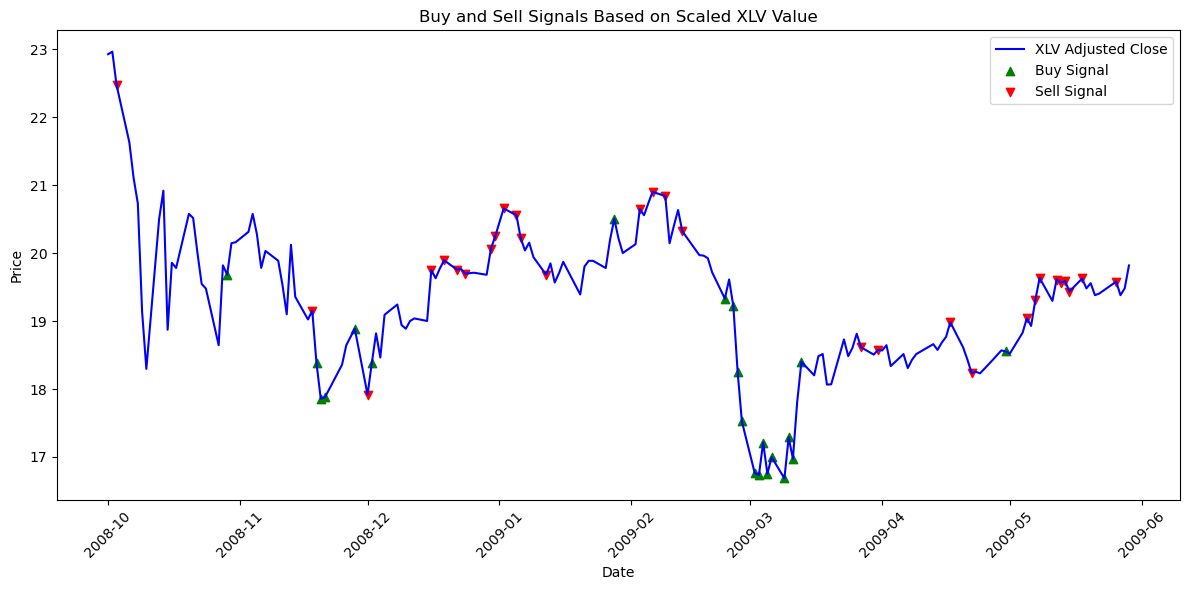

In [38]:
plot_buy_sell_signals(scaled_signals,adj_close_sector_etf,'XLV','trough')

In [39]:
# get the values of different investments
scaled_signals['trough']['XLV'].value_counts()

 0.0    115
-0.4     21
 0.4     10
-0.2      7
 0.2      6
 0.8      5
-0.8      2
Name: XLV, dtype: int64

In [40]:
multple_signals_returns = grid_weighted_technique_roi(weights,signals_dict,adj_close_sector_etf,economic_cycle_periods,economic_cycle_periods_list,sector_etf_tickers,100,0,100,0.2,0.2)

In [41]:
stochastic_roi(sector_etf_tickers,economic_cycle_periods_list,multple_signals_returns,'Mean')

,trough,expansion,peak,contraction,all_data
XLB,17.194471,1.531648,2.716066,0.553094,1.954398
XLI,5.073717,3.046028,5.815485,-0.461453,2.284998
XLF,12.695094,2.85649,9.13101,-4.353104,1.613413
XLK,7.201652,2.240001,3.804137,-1.512942,1.646705
XLY,10.115925,2.274408,1.944565,0.85683,1.275533
XLP,1.372114,4.389305,0.827857,0.970899,1.629162
XLE,5.356899,1.495906,-1.831736,3.736389,1.254475
XLV,2.074749,3.275924,8.545432,-1.319217,1.312276
VOX,6.33744,1.920901,3.608329,-2.694907,0.574173
XLU,-1.886706,1.033054,2.099772,-0.023985,1.641894


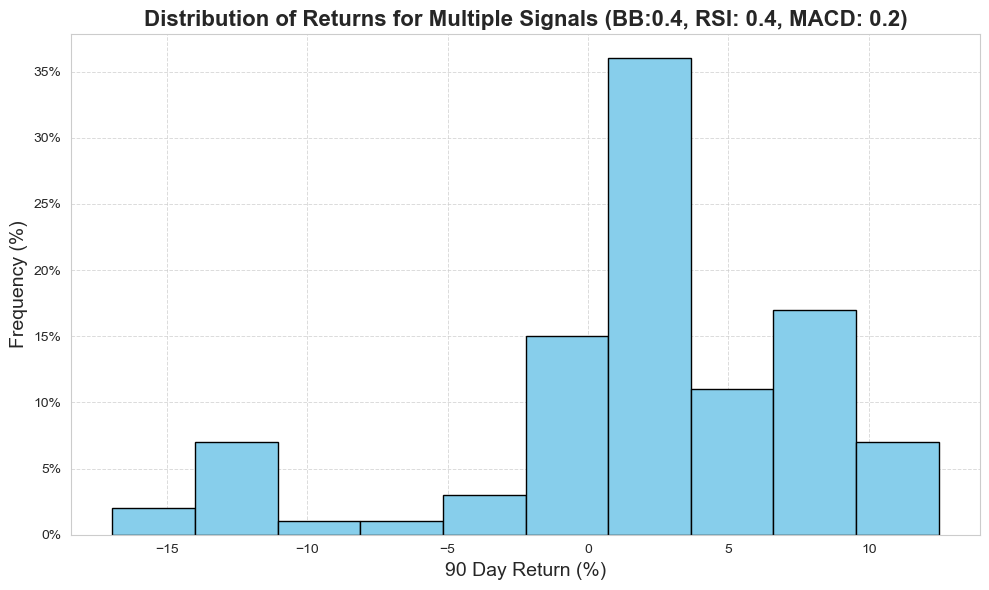

In [42]:
plot_percentage_histogram(multple_signals_returns['trough']['XLV'],'Distribution of Returns for Multiple Signals (BB:0.4, RSI: 0.4, MACD: 0.2)','90 Day Return (%)','Frequency (%)')

In [43]:
stochastic_roi(sector_etf_tickers,economic_cycle_periods_list,multple_signals_returns,'Mean').mean()

trough         6.453280
expansion      2.418823
peak           3.432545
contraction   -0.139717
all_data       1.595952
dtype: float64

In [44]:
stochastic_roi(sector_etf_tickers,economic_cycle_periods_list,multple_signals_returns,'Std').mean()


trough         11.150610
expansion       4.975442
peak            3.916429
contraction     4.854488
all_data        6.693641
dtype: float64

#### Optimal Between Bollinger and RSI

In [45]:
grid_weights  = {
    'Bollinger': [0.2,0.4,0.6,0.8],
    'RSI': [0.2,0.4,0.6,0.8],
    #'MACD': [0.1,0.2,0.4,0.6]
}
roi = grid_search_weighted_technique_roi(grid_weights,signals_dict,adj_close_sector_etf,economic_cycle_periods,economic_cycle_periods_list,sector_etf_tickers,1000,0,100,0.20,0.2)

KeyboardInterrupt: 

In [ ]:
roi.sort_values(by='all_data',ascending=False)

,weights,trough,expansion,peak,contraction,all_data
3,"{'Bollinger': 0.2, 'RSI': 0.8}",9.359273,5.157693,11.980388,-0.909886,3.125422
2,"{'Bollinger': 0.25, 'RSI': 0.7499999999999999}",8.998218,4.626147,10.137968,-0.808884,2.944977
1,"{'Bollinger': 0.3333333333333333, 'RSI': 0.666...",8.411868,3.940158,7.840697,-0.662434,2.675188
7,"{'Bollinger': 0.3333333333333333, 'RSI': 0.666...",8.411868,3.940158,7.840697,-0.662434,2.675188
6,"{'Bollinger': 0.4, 'RSI': 0.6}",7.954662,3.530046,6.521558,-0.561712,2.484548
11,"{'Bollinger': 0.4285714285714286, 'RSI': 0.571...",7.761476,3.383471,6.061491,-0.522252,2.409157
0,"{'Bollinger': 0.5, 'RSI': 0.5}",7.284650,3.079604,5.125917,-0.432323,2.235401
5,"{'Bollinger': 0.5, 'RSI': 0.5}",7.284650,3.079604,5.125917,-0.432323,2.235401
10,"{'Bollinger': 0.5, 'RSI': 0.5}",7.284650,3.079604,5.125917,-0.432323,2.235401
15,"{'Bollinger': 0.5, 'RSI': 0.5}",7.284650,3.079604,5.125917,-0.432323,2.235401


In [ ]:
rsi_bollinger_optimal_weights = {
    'Bollinger': 0.2,
    'RSI': 0.80,
    #'MACD': 0.75
}
optimal_multiple_weights = grid_weighted_technique_roi(rsi_bollinger_optimal_weights,signals_dict,adj_close_sector_etf,economic_cycle_periods,economic_cycle_periods_list,sector_etf_tickers,1000,0,100,0.2,0.2)

In [ ]:
stochastic_roi(sector_etf_tickers,economic_cycle_periods_list,optimal_multiple_weights,'Mean')

,trough,expansion,peak,contraction,all_data
XLB,32.469538,1.609473,3.852463,-0.0361,3.063818
XLI,7.419484,5.452745,16.847502,-0.620742,4.10546
XLF,14.341494,4.323139,32.931725,-5.777415,3.349109
XLK,10.948585,2.401412,4.187888,-2.761181,5.717102
XLY,12.682197,2.919353,1.960104,0.981182,3.647182
XLP,1.307732,23.531071,0.220892,1.330971,3.384703
XLE,7.259812,1.607916,-3.741122,2.591374,2.565864
XLV,3.004352,5.414815,63.483683,-2.382744,2.654424
VOX,7.204436,0.830184,9.054702,-5.950595,2.211268
XLU,-2.077097,2.350149,2.026528,-0.548489,0.626978


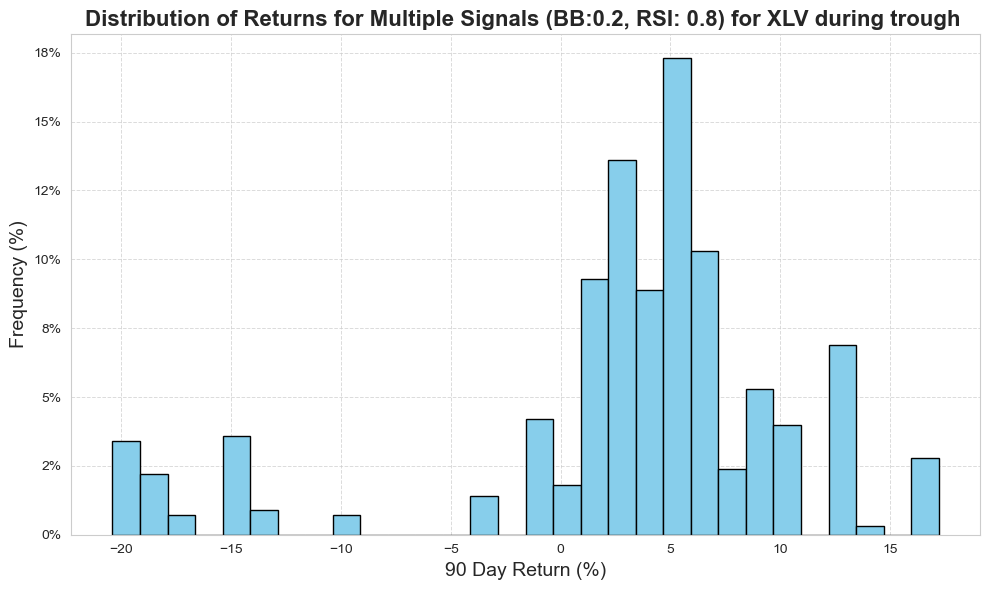

In [ ]:
plot_percentage_histogram(optimal_multiple_weights['trough']['XLV'],'Distribution of Returns for Multiple Signals (BB:0.2, RSI: 0.8) for XLV during trough ','90 Day Return (%)','Frequency (%)',bins=30)

In [ ]:
stochastic_roi(sector_etf_tickers,economic_cycle_periods_list,optimal_multiple_weights,'Mean').mean()

trough          9.359273
expansion       5.157693
peak           11.980388
contraction    -0.909886
all_data        3.125422
dtype: float64

In [ ]:
stochastic_roi(sector_etf_tickers,economic_cycle_periods_list,optimal_multiple_weights,'Mean').std()

trough          9.067679
expansion       6.357125
peak           19.892136
contraction     3.051834
all_data        1.252540
dtype: float64

#### Optimal Between MACD, RSI and Bollinger Band

In [ ]:
grid_weights  = {
    'Bollinger': [0.2,0.4],
    'RSI': [0.4,0.6,0.8],
    'MACD': [0.1,0.2,0.4,0.6]
}
macd_bb_rsi_optimal_search = grid_search_weighted_technique_roi(grid_weights,signals_dict,adj_close_sector_etf,economic_cycle_periods,economic_cycle_periods_list,sector_etf_tickers,1000,0,100,0.20,0.2)

In [ ]:
macd_bb_rsi_optimal_search.sort_values(by='all_data',ascending=False)

,weights,trough,expansion,peak,contraction,all_data
8,"{'Bollinger': 0.18181818181818182, 'RSI': 0.72...",8.596734,4.282233,8.991193,-0.784967,2.811342
4,"{'Bollinger': 0.22222222222222224, 'RSI': 0.66...",8.105858,3.793647,7.432276,-0.688646,2.610935
9,"{'Bollinger': 0.16666666666666669, 'RSI': 0.66...",7.954395,3.719229,7.256915,-0.705650,2.582623
20,"{'Bollinger': 0.30769230769230765, 'RSI': 0.61...",7.839061,3.523792,6.552261,-0.602178,2.482767
5,"{'Bollinger': 0.2, 'RSI': 0.6, 'MACD': 0.2}",7.379550,3.293600,5.984178,-0.620068,2.377749
0,"{'Bollinger': 0.2857142857142857, 'RSI': 0.571...",7.340460,3.223993,5.697756,-0.561851,2.331544
21,"{'Bollinger': 0.2857142857142857, 'RSI': 0.571...",7.340460,3.223993,5.697756,-0.561851,2.331544
16,"{'Bollinger': 0.36363636363636365, 'RSI': 0.54...",7.313389,3.167320,5.467826,-0.512156,2.293735
10,"{'Bollinger': 0.14285714285714288, 'RSI': 0.57...",6.871747,3.086183,5.396092,-0.606854,2.269690
17,"{'Bollinger': 0.33333333333333337, 'RSI': 0.5,...",6.767652,2.912827,4.798225,-0.481663,2.147059


In [ ]:
macd_bb_rsi_optimal_weights = {
    'Bollinger': 0.18,
    'RSI': 0.72,
    'MACD': 0.1
}
macd_bb_rsi_optimal_returns = grid_weighted_technique_roi(macd_bb_rsi_optimal_weights,signals_dict,adj_close_sector_etf,economic_cycle_periods,economic_cycle_periods_list,sector_etf_tickers,1000,0,100,0.2,0.2)

In [ ]:
stochastic_roi(sector_etf_tickers,economic_cycle_periods_list,macd_bb_rsi_optimal_returns,'Mean')

,trough,expansion,peak,contraction,all_data
XLB,28.144987,1.545513,3.68421,-0.16045,2.809667
XLI,7.183078,4.632742,13.617438,-0.752162,3.701131
XLF,14.234169,3.835984,24.636624,-5.581846,2.947148
XLK,9.88165,2.235677,4.744756,-2.561807,4.927443
XLY,11.776686,2.706533,1.975354,0.989608,3.044627
XLP,1.208134,16.472069,0.507555,1.300177,2.677135
XLE,6.400815,1.496358,-2.643209,2.391581,2.625453
XLV,2.852084,4.909299,39.782701,-2.005147,2.269784
VOX,6.378434,1.380255,7.169231,-4.577041,2.184828
XLU,-1.705885,2.111793,1.791727,-0.479051,0.838548


In [ ]:
stochastic_roi(sector_etf_tickers,economic_cycle_periods_list,macd_bb_rsi_optimal_returns,'Mean').mean()

trough         8.520015
expansion      4.207432
peak           8.752790
contraction   -0.774322
all_data       2.782680
dtype: float64

In [ ]:
stochastic_roi(sector_etf_tickers,economic_cycle_periods_list,macd_bb_rsi_optimal_returns,'Std').mean()

trough         15.629597
expansion      19.046965
peak           20.998206
contraction     6.720428
all_data       30.840679
dtype: float64

#### RSI, Bollinger Bands and Buy/Hold

In [ ]:
buy_hold_optimal_multiple_weights = grid_weighted_technique_roi(rsi_bollinger_optimal_weights,signals_dict,adj_close_sector_etf,economic_cycle_periods,economic_cycle_periods_list,sector_etf_tickers,1000,40,100,0.2,0.2)


In [ ]:
stochastic_roi(sector_etf_tickers, economic_cycle_periods_list, buy_hold_optimal_multiple_weights,'Mean')

,trough,expansion,peak,contraction,all_data
XLB,28.643325,1.197702,3.142779,-1.63168,4.235866
XLI,0.992195,12.194393,18.300111,-2.205144,5.44736
XLF,6.787534,8.88846,55.691408,-8.208079,4.991745
XLK,8.565164,-21.659095,37.179087,-4.520359,-4.378319
XLY,8.890946,7.962113,-0.836925,-0.770413,-8.855474
XLP,-1.746132,106.60281,2.726925,0.722609,9.04996
XLE,4.028144,0.693899,-6.819301,1.054483,13.043873
XLV,-4.659729,20.118756,131.461836,-3.875752,-0.593599
VOX,6.163351,3.338647,9.545183,-16.83298,1.050945
XLU,-4.38989,-5.132705,2.883247,-1.643792,-2.484873


In [ ]:
stochastic_roi(sector_etf_tickers, economic_cycle_periods_list, buy_hold_optimal_multiple_weights,'Mean').mean()

trough          5.026661
expansion      13.094072
peak           23.144726
contraction    -3.302547
all_data        2.160440
dtype: float64

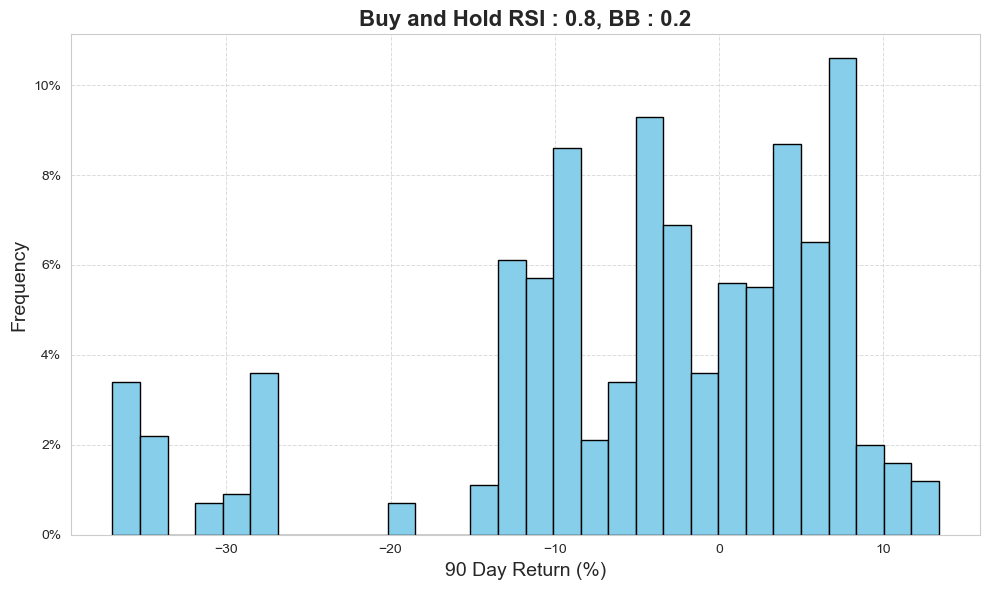

In [ ]:
plot_percentage_histogram(buy_hold_optimal_multiple_weights['trough']['XLV'],'Buy and Hold RSI : 0.8, BB : 0.2','90 Day Return (%)','Frequency',bins=30)

In [ ]:
buy_hold_optimal_multiple_weights['expansion']['XLV']

[19.88676052466912,
 76.25233998519305,
 -22.600685197845515,
 8.07655164533084,
 15.709367228832727,
 -3.0748634749556913,
 40.0524850070659,
 47.27054768093272,
 28.937747308679683,
 -14.509711729341623,
 51.45005187781213,
 -29.142651951058106,
 11.765027558875381,
 -33.06489598028276,
 3.404089141864972,
 118.09718132793023,
 17.193374166382764,
 6.718878695866855,
 67.62046706463155,
 20.62564245817693,
 12.986876439650002,
 38.42742813983916,
 25.7869078441042,
 94.46817006254605,
 -8.884998459666917,
 88.5442891758716,
 6.698303597517159,
 -3.8321651668253964,
 19.38199554895667,
 -8.059199823183008,
 -18.46912772174554,
 12.104339714156335,
 123.52792416123715,
 -16.146801148070804,
 30.330319557817965,
 5.146614639418366,
 -1.0681682906007546,
 -44.92296808225027,
 41.43878998722682,
 38.5240353782761,
 83.04407290425259,
 -1.952617309189821,
 -44.25244441316084,
 -57.05974019832768,
 -2.322249663006671,
 32.876091544750516,
 11.615416171281774,
 4.705128007407759,
 -0.1818652

In [ ]:
stochastic_roi(sector_etf_tickers, economic_cycle_periods_list, buy_hold_optimal_multiple_weights,'Std')

,trough,expansion,peak,contraction,all_data
XLB,38.905093,9.492467,10.132104,8.817597,32.835995
XLI,19.340347,30.943138,28.402158,4.810994,115.661222
XLF,33.667038,30.4683,58.082591,7.558369,73.149578
XLK,10.474064,139.318722,76.855673,7.604886,159.583991
XLY,19.3936,24.805184,7.77801,4.223333,218.497542
XLP,7.777767,355.910567,2.237934,1.840241,114.957886
XLE,9.597911,20.67655,11.795187,18.775951,107.742845
XLV,11.936563,55.847346,331.886476,7.460366,89.849293
VOX,6.052638,19.922626,28.880751,24.519361,43.561507
XLU,9.814165,143.763296,5.977864,5.977958,62.492122


### Testing Model
Using RSI: 0.8, BB: 0.2 and a 40% of  future investments already invested in the stocks.

In [ ]:
# create time periods for where this takes place
deployment = {
    "deployment": ("2024-01-01", "2024-10-01")
}

In [ ]:
tickers = [
    'NVDA',
    'SBUX',
    'AAPL',
    'META',
    'TSLA',
    'BABA',
    'DIS',
    'NFLX',
    'SNAP',
    'UBER',
    'AMZN',
    'TGT'
]

In [ ]:
rsi_bollinger_optimal_weights

{'Bollinger': 0.2, 'RSI': 0.8}

In [ ]:
deployment_data = download_stock_data_for_periods(tickers,deployment)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [ ]:
deployment_adj_close = get_adjusted_closed_price(deployment_data,tickers,deployment)

In [ ]:
# create bollinger bands

In [ ]:
deployment_data = bollinger_data_multiple_periods_tickers(deployment,tickers,deployment_data,20,0.95)

In [ ]:
# create the data for rsi
deployment_data = rsi_value(deployment_data,deployment.keys(),tickers,14)

In [ ]:
deployment_data = create_rsi_signal(deployment_data,deployment.keys(),tickers)

In [ ]:
deployment_dict = collect_signals(deployment_data,['Bollinger','MACD','RSI'],tickers,deployment.keys())

In [ ]:
deployment_dict

{'deployment': {'Bollinger':             NVDA  SBUX  AAPL  META  TSLA  BABA   DIS  NFLX  SNAP  UBER  AMZN  \
  Date                                                                           
  2024-01-02  Hold  Hold  Hold  Hold  Hold  Hold  Hold  Hold  Hold  Hold  Hold   
  2024-01-03  Hold  Hold  Hold  Hold  Hold  Hold  Hold  Hold  Hold  Hold  Hold   
  2024-01-04  Hold  Hold  Hold  Hold  Hold  Hold  Hold  Hold  Hold  Hold  Hold   
  2024-01-05  Hold  Hold  Hold  Hold  Hold  Hold  Hold  Hold  Hold  Hold  Hold   
  2024-01-08  Hold  Hold  Hold  Hold  Hold  Hold  Hold  Hold  Hold  Hold  Hold   
  ...          ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
  2024-09-24  Hold  Hold  Hold  Hold  Sell  Sell  Hold  Sell  Sell  Sell  Hold   
  2024-09-25  Hold  Hold  Hold  Hold  Hold  Sell  Hold  Hold  Hold  Hold  Hold   
  2024-09-26  Hold  Hold  Hold  Hold  Hold  Sell  Hold  Hold  Hold  Hold  Hold   
  2024-09-27  Hold  Hold  Hold  Hold  Hold  Sell  Hold  Hold  Hold  Hol

In [ ]:
deployment_data['deployment']

{'NVDA':                   Open        High         Low       Close   Adj Close  \
 Date                                                                     
 2024-01-02   49.243999   49.294998   47.595001   48.167999   48.157665   
 2024-01-03   47.485001   48.183998   47.320000   47.569000   47.558796   
 2024-01-04   47.766998   48.500000   47.507999   47.998001   47.987705   
 2024-01-05   48.462002   49.547001   48.306000   49.097000   49.086464   
 2024-01-08   49.512001   52.275002   49.479000   52.252998   52.241787   
 ...                ...         ...         ...         ...         ...   
 2024-09-24  116.519997  121.800003  115.379997  120.870003  120.870003   
 2024-09-25  122.019997  124.940002  121.610001  123.510002  123.510002   
 2024-09-26  126.800003  127.669998  121.800003  124.040001  124.040001   
 2024-09-27  123.970001  124.029999  119.260002  121.400002  121.400002   
 2024-09-30  118.309998  121.500000  118.150002  121.440002  121.440002   
 
               

In [ ]:
multple_signals_returns = grid_weighted_technique_roi(weights,signals_dict,adj_close_sector_etf,economic_cycle_periods,economic_cycle_periods_list,sector_etf_tickers,100,0,100,0.2,0.2)

In [ ]:
deployment_returns = grid_weighted_technique_roi(rsi_bollinger_optimal_weights,deployment_dict,deployment_adj_close,deployment,deployment.keys(),tickers,100,0,100,0.2,0.2)

In [ ]:
stochastic_roi(tickers,deployment.keys(), deployment_returns,'Mean')

,deployment
NVDA,21.110064
SBUX,-1.381934
AAPL,8.615309
META,4.400137
TSLA,5.721222
BABA,3.787236
DIS,-4.387078
NFLX,5.802604
SNAP,1.060397
UBER,-0.780517
